<a href="https://colab.research.google.com/github/ttjh1234/Study_MLDL/blob/main/chapter09_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

순차 데이터는 텍스트나 시계열 데이터와 같이 순서에 의미가 있는 데이터를 말한다.

이러한 데이터들은 순서를 유지하며 신경망에 넣어주어야 한다. 따라서 순차 데이터를 다룰때는 이전에 입력한 데이터를 기억하는 기능이 필요하다.

완전 연결 신경망이나 합성곱 신경망은 이러한 장치가 없다. 하나의 샘플을 사용하여 정방향 계산을 수행하고 나면 그 샘플은 버려지고 다음 샘플을 처리할 때 재사용되지 않는다.

이렇게 입력 데이터의 흐름이 앞으로만 전달되는 신경망을 

**피드포워드 신경망(feedforward neural network)** 이라고 한다.

이에 비해 순차 데이터들은 이전에 처리했던 샘플들을 재사용해야하므로 신경망 층에 순환될 필요가 있다. 이런 신경망이 순환 신경망이다.

**순환 신경망(recurrent neural network)** 은 일반적인 완전 연결 신경망과 거의 비슷한데, 이전 데이터의 처리 흐름을 순환하는 고리만 추가하면 된다.

순환 신경망은 이전 샘플에 대한 기억을 가지고 있는데, 이렇게 샘플을 처리하는 한 단계를 **타임 스텝(timestep)** 이라고 한다.

순환 신경망은 이전 타임스텝의 샘플을 기억하지만 타임스텝이 오래될수록 순환되는 정보는 희미해진다. 

순환 신경망에서는 특별히 층을 **셀(cell)**이라고 한다. 한 셀에는 여러 개의 뉴런이 있지만, 완전 연결 신경망과 달리 뉴런을 모두 표시하지 않고, 하나의 셀로 층을 표현한다.

셀의 출력을 **은닉 상태(hidden state)**라고 부른다.

일반적으로 순환층에서 활성화함수는 tanh함수를 사용한다.(sigmoid함수의 기울기 소실 문제 때문.)


## IMDB 리뷰 데이터셋

이번 장에서는 IMDB 리뷰 dataset을 사용한다.

IMDB 리뷰 dataset은 유명한 인터넷 영화 데이터베이스인 imdb.com 에서 수집한 리뷰를 

감상평에 따라 긍정과 부정으로 분류해 놓은 dataset이다.

총 50000개의 샘플을 가지고 있고, train_set과 test_set가 각각 25000개씩 나뉘어져 있다.

텍스트 데이터를 사용하는데 컴퓨터는 텍스트를 곧 바로 이해하고 사용할 수 없다.

따라서 단어를 숫자 데이터를 바꾸는 작업을 해야한다.

이렇게 숫자 데이터로 바뀌어서 분리된 단어를 **토큰** 이라고 한다. 

즉 하나의 샘플은 여러개의 토큰으로 이루어져 있고, 1개의 토큰이 하나의 타임스탬프가 된다. 

한글은 조사가 발달되어 있어 공백으로 나누는 것만으로 부족하다.

일반적으로 한글은 형태소 분석을 통해 토큰을 만드는데, **KoNLPy**를 사용하여 분석을 진행할 수 있다.

우선 IMDB dataset은 영어로 이루어져 있기 때문에, KoNLPy를 사용하지 않고 분석을 진행하겠다.

첫 번째 방법으로는 원 핫 인코딩을 사용하여 진행해보겠다.




In [1]:
from tensorflow.keras.datasets import imdb
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=500)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

데이터는 케라스의 datasets 패키지 아래 imdb 모듈을 임포트해서 가져온다.

매개변수인 num_words를 사용하여 전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용한다.

In [2]:
print(x_train.shape,x_test.shape)

(25000,) (25000,)


dataset을 가져와 train_set과 test_set의 모양을 보니, 1차원 배열로 이루어져 있다.

리뷰 텍스트는 길이가 제각각이라 각 샘플은 파있너 리스트 객체로 이루어진 넘파이 배열이다.


In [3]:
print(len(x_train[0]))

218


In [4]:
print(len(x_train[1]))

189


In [5]:
print(x_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


앞서 설명했듯이 tensorflow에 있는 IMDB 리뷰 data는 이미 정수로 변환되어 있다.

num_words=500으로 지정했기 때문에 어휘 사전에는 500개의 단어만 들어가 있고, 어휘 사전에 없는 단어는 모두 2로 표현된다.

어휘 사전은 train_set에서 고유한 단어를 뽑아 만든 목록을 일컫는다.

test_set 안에 어휘 사전에 없는 단어가 있다면 2로 변환하여 신경망 모델에 투입된다.

어휘 사전에는 0은 패딩, 1은 문장의 시작, 2는 어휘 사전에 없는 토큰을 나타낸다.

In [6]:
print(y_train[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


이번에 문제는 각 리뷰가 긍정인지 부정인지를 다루는 이진 분류 문제이다.

따라서 0은 부정 1은 긍정으로 결과가 나타난다.

이제 train_set의 20%를 검증세트로 나눠본다.

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [8]:
import numpy as np
lengths=np.array([len(x) for x in x_train])

In [10]:
print(np.mean(lengths),np.median(lengths))

239.00925 178.0


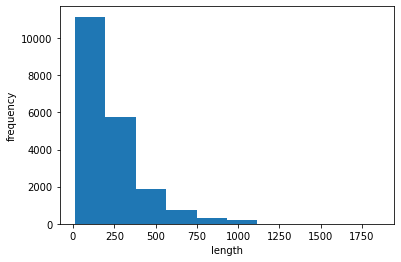

In [11]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

valid_set을 나누고, train_set에 있는 리뷰들의 길이의 평균, 중간값을 구하고, 길이에 대한 히스토그램을 그려보았다.

평균이 중간값보다 높은 이유는 길이가 큰 리뷰들이 있었기 때문에, 중간값보다 더 컸다.

리뷰는 대부분 짧아서 중간값보다 짧은 100개의 단어만 사용하겠다.

100보다 작은 리뷰들은 분석을 길이를 맞추기 위해 패딩을 진행하여야 하는데, 패딩은 0으로 한다.

물론 수동으로 모든 데이터들을 자르고 0으로 추가할 수 있지만, keras에서는 유용한 함수를 제공한다.

**pad_sequences()**라는 함수인데, 패딩할 배열과 원하는 길이를 지정해주는 **maxlen**이라는 매개변수를 사용한다.

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train_seq=pad_sequences(x_train,maxlen=100)

In [13]:
print(x_train_seq.shape)

(20000, 100)


In [14]:
print(x_train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


x_train의 첫 번째 샘플을 확인해보았는데, 보통 패딩을 하게되면 0으로 채워지게된다.

이 경우 앞과 뒤에 0이 없는 것을 보아 100자 보다 길었을 것이다.

앞과 뒤 중 어느 부분이 잘렸는지 확인해본다.

In [15]:
print(x_train_seq[0][-10:])

[  6   2  46   7  14  20  10  10 470 158]


뒤를 확인한 결과 정확하게 동일했다. 이는 즉 앞에가 잘렸다는 것을 알 수 있다.

pad_sequences() 함수는 기본적으로 maxlen보다 긴 시퀀스의 앞부분을 자른다.

이렇게 하는 이유는 일반적으로 뒷부분의 정보가 유용하다고 생각하기 때문이다.

만약 시퀀스의 뒷부분을 자르고 싶으면, truncating 매개변수의 값을 기본값 'pre'가 아닌 'post'로 지정하면 된다.

In [16]:
print(x_train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


여섯번 째 데이터는 앞에 0이 패딩 된것으로 보아 본 리뷰의 길이가 100자보다 작았던 것을 알 수 있다.

이제 분석에 앞서 valid_set도 같은 방식으로 100자로 줄이겠다.

In [17]:
x_valid_seq=pad_sequences(x_valid,maxlen=100)

## 순환 신경망 만들기

keras는 여러 종류의 순환층 클래스를 제공하는데, 가장 간단한 것이 SimpleRNN 클래스이다.

In [18]:
from tensorflow import keras
model=keras.Sequential()
model.add(keras.layers.SimpleRNN(8,input_shape=(100,500)))
model.add(keras.layers.Dense(1,activation='sigmoid'))

SimpleRNN의 첫 번째 매개변수는 뉴런의 개수로 input_shape는 (100,500)으로 지정했다.

첫 번째 차원이 100인 것은 앞에서 샘플의 길이를 100으로 지정했기 때문이다.

두 번째 차원은 앞으로 진행할 것이지만, 원 핫 인코딩을 하여 어휘 사전의 수 만큼 500개로 나누어서 진행할 것이기 때문에 500으로 지정했다.

순환층도 활성화 함수가 있는데 기본값이 tanh 함수를 사용한다.

이전에서 만들었던 텍스트의 토큰화를 보면, 큰 정수가 활성화함수를 만나 큰 값으로 변환되기 때문에, 잘못된 결과를 초래할 수 있다.

따라서 값의 크기를 줄이기 위해서, 원 핫 인코딩을 사용하여 변환해준다.

keras에서는 원 핫 인코딩을 위한 유틸리티를 제공한다.

**keras.utils** 패키지 아래에 있는 **to_categorical()** 함수를 사용한다.

In [19]:
x_train_oh=keras.utils.to_categorical(x_train_seq)

In [20]:
print(x_train_oh.shape)

(20000, 100, 500)


원래 x_train_seq에서 들어있는 정수 하나하나 값마다 모두 500차원의 배열로 변경되었기 때문에, (20000,100) 크기가 (20000,100,500)이 되었다.

이제 원 핫 인코딩이 잘되었나 확인해보겠다.

In [21]:
print(x_train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [22]:
print(np.sum(x_train_oh[0][0]))

1.0


이제 똑같이 valid_set도 원 핫 인코딩을 진행해준다.

In [23]:
x_valid_oh=keras.utils.to_categorical(x_valid_seq)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8)                 4072      
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


SimpleRNN에 전달한 샘플의 크기는 (100,500) 이지만 이 순환층은 마지막 타임스텝의 은닉 상태만 출력한다. 이 때문에 출력 크기가 뉴런의 수와 동일하다.

모델 파라미터를 계산해보면, 500개의 원핫 인코딩 배열이 순환층의 뉴런 8개와 완전 연결되기 때문에, 
총 4000개의 파라미터가 나오고, 순환층의 은닉 상태는 다시 다음 타임스텝에 사용되고, 이 은닉 상태도 순환층의 뉴런들과 완전 연결되기 때문에, 64개의 가중치가 필요하고, 뉴런마다 한 개씩 절편을 가지고 있어 총 4072개가 된다.


## 순환 신경망 훈련하기

순환 신경망의 훈련도 이전에 배웠었던 신경망들과 다르지 않다.

여기서는 RMSprop의 학습률을 0.0001로 지정하고 에포크를 100으로 배치 크기는 64개로 설정해서 진행하겠다.

In [25]:
rmsprop=keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
histroy=model.fit(x_train_oh,y_train,epochs=100,batch_size=64,validation_data=(x_valid_oh,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 23s 67ms/step - loss: 0.7008 - accuracy: 0.5047 - val_loss: 0.6980 - val_accuracy: 0.4982
Epoch 2/100
313/313 [==============================] - 21s 66ms/step - loss: 0.6941 - accuracy: 0.5219 - val_loss: 0.6897 - val_accuracy: 0.5302
Epoch 3/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6840 - accuracy: 0.5533 - val_loss: 0.6798 - val_accuracy: 0.5704
Epoch 4/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6706 - accuracy: 0.5959 - val_loss: 0.6643 - val_accuracy: 0.6098
Epoch 5/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6556 - accuracy: 0.6317 - val_loss: 0.6469 - val_accuracy: 0.6428
Epoch 6/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6377 - accuracy: 0.6619 - val_loss: 0.6283 - val_accuracy: 0.6640
Epoch 7/100
313/313 [==============================] - 21s 66ms/step - loss: 0.6190 - accuracy: 0.6803 - val_loss: 0.6129 - val_ac

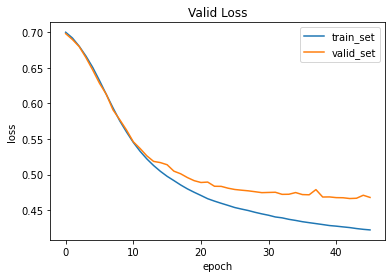

In [28]:
plt.plot(histroy.history['loss'])
plt.plot(histroy.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Valid Loss')
plt.legend(['train_set','valid_set'])
plt.show()

훈련 손실은 꾸준히 감소하고 있지만, 검증 손실은 대략 20번째 에포크에서 감소가 더뎌지고있다.

순환 신경망을 가지고 긍정과 부정을 분류해보았지만, 원 핫 인코딩으로 변환을 해서 데이터가 굉장히 커졌다.

x_train_seq와 x_train_oh의 크기를 비교해보겠다.

In [29]:
print(x_train_seq.nbytes,x_train_oh.nbytes)

8000000 4000000000


토큰 1개당 500개의 차원으로 늘려서 대략 500배가 커졌다.

이를 해결하기 위해 **단어 임베딩** 방법을 사용하겠다.

## 단어 임베딩을 사용하기

순환 신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법은 **단어 임베딩(word embedding)**이다.

단어 임베딩은 각 단어를 고정된 크기의 실수 벡터로 바꾸어 준다.

이러한 단어 임베딩으로 만들어진 벡터는 원 핫 인코딩된 벡터보다 훨씬 의미 있는 값으로 채워져 있기 때문에 자연어 처리에서 더 좋은 성능을 내는 경우가 많다.

단어 임베딩은 keras.layers 패키지 아래 Embedding 클래스로 제공한다.

이 층을 추가하면 처음에는 모든 벡터들이 랜덤하게 초기화되지만, 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습한다.


In [30]:
model2=keras.Sequential()
model2.add(keras.layers.Embedding(500,16,input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1,activation='sigmoid'))

Embedding 클래스의 첫 번째 매개변수는 어휘 사전의 크기이다.

두 번째 매개변수는 임베딩 벡터의 크기이다. 

세 번째 매개변수는 입력 시퀀스의 길이이다.

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


출력 결과를 보면 (100,) 크기의 입력을 받아 (100,16) 크기의 출력을 만든다.

Embedding 클래스는 500개의 각 토큰을 크기가 16인 벡터로 변경하기 때문에, 8000개의 모델 파라미터를 갖는다.
그 다음 순환층에서는 16개의 출력을 가지고 8개의 뉴런과 곱하기 위해 필요한 가중치 128개를 가지고, 은닉 상태에 곱해지는 가중치 64개, 절편 8개 를 포함하여 200개의 모델 파라미터가 있다. Dense층에서는 9개가 존재한다.

In [33]:
rmsprop=keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
history=model2.fit(x_train_seq,y_train,epochs=100,batch_size=64,validation_data=(x_valid_seq,y_valid),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 63ms/step - loss: 0.6917 - accuracy: 0.5230 - val_loss: 0.6666 - val_accuracy: 0.6384
Epoch 2/100
313/313 [==============================] - 20s 63ms/step - loss: 0.6583 - accuracy: 0.6589 - val_loss: 0.6399 - val_accuracy: 0.6990
Epoch 3/100
313/313 [==============================] - 19s 62ms/step - loss: 0.6329 - accuracy: 0.7068 - val_loss: 0.6192 - val_accuracy: 0.7090
Epoch 4/100
313/313 [==============================] - 19s 61ms/step - loss: 0.6074 - accuracy: 0.7296 - val_loss: 0.5935 - val_accuracy: 0.7436
Epoch 5/100
313/313 [==============================] - 20s 63ms/step - loss: 0.5817 - accuracy: 0.7522 - val_loss: 0.5707 - val_accuracy: 0.7490
Epoch 6/100
313/313 [==============================] - 19s 62ms/step - loss: 0.5544 - accuracy: 0.7644 - val_loss: 0.5477 - val_accuracy: 0.7644
Epoch 7/100
313/313 [==============================] - 20s 65ms/step - loss: 0.5312 - accuracy: 0.7774 - val_loss: 0.5320 - val_ac

출력 결과를 보면 원 핫 인코딩을 사용한 모델과 비슷한 성능을 냈다.

반면에 순환층의 가중치 개수도 작고, 훈련 세트의 크기도 훨씬 줄었다.


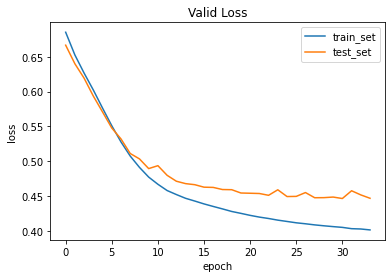

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_set','test_set'])
plt.title('Valid Loss')
plt.show()

검증 손실이 더 감소되지 않아 훈련이 적절히 조기 종료가 되었다.

이에 비해 훈련 손실은 계속 감소하는데, 아쉬움이 따른다.

다음 방법으로 고급 순환층인 **LSTM**과 **GRU** 에대해 학습해보도록 하겠다.